In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from keras_tqdm import TQDMNotebookCallback
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import tensorflow as tf
from tensorflow.keras import layers

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raquib/anaconda3/envs/tmseeg/lib/python3

In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
experiment = 'data/original/*/*'
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean-prestimulus.set'))
eeg_present = len(eegs) > 0
cmaps = sorted(glob.glob(experiment + '/cmap/*.xlsx'))
cmap_present = len(cmaps) > 0
all_present = mep_present and eeg_present and cmap_present
print(all_present)

True


In [4]:
print('EEG count: ' + str(len(eegs)))
print('MEP count: ' + str(len(meps)))
print('CMAP count: ' + str(len(cmaps)))

EEG count: 44
MEP count: 77
CMAP count: 22


In [5]:
eegs

['data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
 'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
 'data/original/sub05/exp02/eeg/SP 120RMT r2/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
 'data/original/sub06/exp01/eeg/SP

In [6]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub16/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [7]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

# Calculate EEG area.
def calculate_eeg_area(epoch_df, sf=2048):
    y = epoch_df.drop('time', axis=1).mean(axis=1)
    b2, a2 = signal.butter(4, 200/(sf/2), btype='lowpass')
    envelope = signal.filtfilt(b2, a2, np.abs(y))
    area = np.trapz(envelope, epoch_df['time'].values)
    return area

# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 2048
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

def band_max(freq, psd, interval):
    indices = []
    for el in freq:
        indices.append(el in interval)
    freq = freq[indices]
    psd = psd[indices]
    if (len(psd) == 0):
        return 0, 0
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

def read_wavelets(sub, exp, run, epoch_num):
    path = 'wavelets/' + sub + '-' + exp + '-' + run + '-' + str(epoch_num)
    with open(path + '-central.pickle', 'rb') as f:
        central = pickle.load(f)
    with open(path + '-ltm1.pickle', 'rb') as f:
        ltm1 = pickle.load(f)
    with open(path + '-rtm1.pickle', 'rb') as f:
        rtm1 = pickle.load(f)
    with open(path + '-all.pickle', 'rb') as f:
        all_channels = pickle.load(f)
    return all_channels, ltm1, rtm1, central

def wavelet_band_max(df, interval):
    indices = []
    for el in (df.index * 1000):
        indices.append(el in interval)
    df = df[indices]
    if (df.shape[0] == 0):
        return 0, 0, 0, 0
    return df.mean(axis=1).max(), df.mean(axis=1).argmax() * 1000, df.mean(axis=0).max(), df.mean(axis=0).argmax()

# Read features file

In [8]:
features_filename = '55-features-v1.xlsx'

In [9]:
df = pd.read_excel(features_filename, index_col=0)

p1 = np.percentile(df['mep_category_cmap'], 50)
cat = np.ones(len(df['mep_category_cmap'])) * (df['mep_category_cmap'] > p1)
df['mep_category_cmap_across_subjects'] = cat

# Prepare wavelet dataframe

In [10]:
start_time_sec = -100
end_time_sec = -20

wt_large_all_all, wt_large_ltm1_all, wt_large_rtm1_all, wt_large_central_all, wt_small_all_all, wt_small_ltm1_all, wt_small_rtm1_all, wt_small_central_all = np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164))
wt_large_all_all_avg, wt_large_ltm1_all_avg, wt_large_rtm1_all_avg, wt_large_central_all_avg, wt_small_all_all_avg, wt_small_ltm1_all_avg, wt_small_rtm1_all_avg, wt_small_central_all_avg = np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164)), np.zeros((52, 164))

df_wt = []
        
for idx, epoch in tqdm_notebook(df.iterrows(), total=df.shape[0]):
    wt_all, wt_ltm1, wt_rtm1, wt_central = read_wavelets(epoch['sub'], epoch['exp'], epoch['run'], epoch['epoch'])

    # Drop last 9 rows (freq 0 to 2Hz)
    wt_all = wt_all[(wt_all.index * 1000 > 6) * (wt_all.index * 1000 < 50)]
    wt_ltm1 = wt_ltm1[(wt_ltm1.index * 1000 > 6) * (wt_ltm1.index * 1000 < 50)]
    wt_rtm1 = wt_rtm1[(wt_rtm1.index * 1000 > 6) * (wt_rtm1.index * 1000 < 50)]
    wt_central = wt_central[(wt_central.index * 1000 > 6) * (wt_central.index * 1000 < 50)]

    # Take only last 100ms - 0
    wt_all = wt_all.loc[:, wt_all.columns.isin(wt_all.columns[(wt_all.columns >= (start_time_sec/1000)) * (wt_all.columns <= (end_time_sec/1000))])]
    wt_ltm1 = wt_ltm1.loc[:, wt_ltm1.columns.isin(wt_ltm1.columns[(wt_ltm1.columns >= (start_time_sec/1000)) * (wt_ltm1.columns <= (end_time_sec/1000))])]
    wt_rtm1 = wt_rtm1.loc[:, wt_rtm1.columns.isin(wt_rtm1.columns[(wt_rtm1.columns >= (start_time_sec/1000)) * (wt_rtm1.columns <= (end_time_sec/1000))])]
    wt_central = wt_central.loc[:, wt_central.columns.isin(wt_central.columns[(wt_central.columns >= (start_time_sec/1000)) * (wt_central.columns <= (end_time_sec/1000))])]
    
    val = wt_ltm1.values.flatten()
    val = np.append(val, epoch['mep_category_cmap_across_subjects'])
    df_wt.append(val)        

In [11]:
df_wt2 = np.array(df_wt)
df_wt2 = pd.DataFrame(df_wt2)

# Linear regression

In [12]:
x = df_wt2.drop(df_wt2.columns[len(df_wt2.columns)-1], axis=1)
y = df_wt2[df_wt2.columns[-1]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=12)

In [13]:
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

y_pred = y_pred > 0.5
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5028571428571429
[[93 82]
 [92 83]]
             precision    recall  f1-score   support

        0.0       0.50      0.53      0.52       175
        1.0       0.50      0.47      0.49       175

avg / total       0.50      0.50      0.50       350



# Random forest

In [14]:
reg = RandomForestClassifier(n_estimators = 4000, random_state = 42)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test) > 0.5
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5485714285714286
[[102  73]
 [ 85  90]]
             precision    recall  f1-score   support

        0.0       0.55      0.58      0.56       175
        1.0       0.55      0.51      0.53       175

avg / total       0.55      0.55      0.55       350



# Gradient boosting

In [15]:
reg = GradientBoostingClassifier(n_estimators = 2000, random_state = 42)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test) > 0.5
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5171428571428571
[[96 79]
 [90 85]]
             precision    recall  f1-score   support

        0.0       0.52      0.55      0.53       175
        1.0       0.52      0.49      0.50       175

avg / total       0.52      0.52      0.52       350



# SVM

In [ ]:
reg = SVC(kernel='rbf')
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test) > 0.5
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Decision tree

In [ ]:
reg = DecisionTreeClassifier()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test) > 0.5
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Keras

In [34]:
cb = TQDMNotebookCallback(show_inner=False)
cb.on_train_batch_begin = cb.on_batch_begin
cb.on_train_batch_end = cb.on_batch_end
cb.on_test_begin = cb.on_train_begin
cb.on_test_end = cb.on_train_end
cb.on_test_batch_begin = cb.on_batch_begin
cb.on_test_batch_end = cb.on_batch_end


plcb = PlotLossesCallback()
# plcb.on_train_batch_begin = plcb.on_batch_begin
# plcb.on_train_batch_end = plcb.on_batch_end
# plcb.on_test_begin = plcb.on_train_begin
# plcb.on_test_end = plcb.on_train_end
# plcb.on_test_batch_begin = plcb.on_batch_begin
# plcb.on_test_batch_end = plcb.on_batch_end


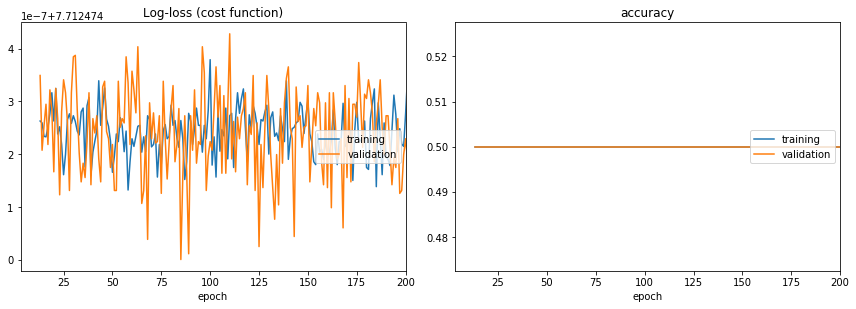

Log-loss (cost function):
training   (min:    7.712, max:    7.769, cur:    7.712)
validation (min:    7.712, max:    7.712, cur:    7.712)

accuracy:
training   (min:    0.496, max:    0.500, cur:    0.500)
validation (min:    0.500, max:    0.500, cur:    0.500)


In [36]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.Dense(256, activation='relu', input_dim=x_train.shape[1]))
classifier.add(tf.keras.layers.Dense(256, activation='relu'))
classifier.add(tf.keras.layers.Dense(1, activation='sigmoid'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=200, callbacks=[plcb], verbose=0)

In [19]:
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.5
[[  0 175]
 [  0 175]]
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       175
        1.0       0.50      1.00      0.67       175

avg / total       0.25      0.50      0.33       350



/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
